In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import List
import seaborn as sns

In [2]:
#Удаляем значения лежащие за пределами квантилей
def delete_outliers(data_frame: pd.DataFrame):
    for column_name in ['Рлин', 'Рлин_1', 'Туст', 'Тна шлейфе', 'Тзаб', 'Дебит ст. конд.', 'Дебит кон нестабильный',
              'Рпл. Тек (Карноухов)', 'Удельная плотность газа ']:
        column = data_frame[column_name]
        quant = np.nanquantile(column, q=[0.25, 0.75])
        low = quant[0] - 1.5 * (quant[1] - quant[0])
        high = quant[1] + 1.5 * (quant[1] - quant[0])
        for index, row in data_frame.iterrows():
            aux = data_frame[column_name].loc[index]
            if not (low < aux < high) and np.isnan(data_frame["G_total"].loc[index]):
                data_frame.drop(index, inplace=True)
    return data_frame

In [3]:
#Дропаем колонки в которых nan'ов больше чем 50 процентов
def delete_big_nan(data_frame: pd.DataFrame):
    nan_count_series = data_frame.isnull().sum(axis=0)
    column_size = data_frame.shape[0]
    for i, v in nan_count_series.iteritems():
        #print(" ", i, end=" ")
        #print(v / column_size * 100)
        if v / column_size * 100 >= 50 and i != "G_total":
            data_frame.drop(i, axis=1, inplace=True)
    
    return data_frame

In [4]:
#Дропаем колонки значения которых не уникальны
def delete_small_uniques(data_frame: pd.DataFrame):
    del_list = []
    for i in data_frame.columns:
        if data_frame[i].nunique(dropna=True) == 1:
            data_frame.drop(i, axis=1, inplace=True)
            
    return data_frame

In [5]:
#Переименовываем колонки с одинаковымии названиями
def rename_columns(columns):
    repeated = {}
    new_column_names = []
    for column in columns:
        if column in new_column_names:
            if column not in repeated:
                repeated[column] = 1
            else:
                repeated[column] += 1
            column = column + "_" + str(repeated[column])
        new_column_names.append(column)
    return new_column_names

def clean_data_frame(data_frame: pd.DataFrame):
    data_frame.iloc[0, 0] = data_frame.iloc[1, 0]
    data_frame.iloc[0, 1] = "Дата"
    data_frame.columns = data_frame.iloc[0]
    #Некоторые колонки названы неправильно
    data_frame.rename(columns={'Pлин': 'Рлин'}, inplace=True)
    data_frame.rename(columns={'Дебит гааз': 'Дебит газа'}, inplace=True)
    #Помечаем повторяющиеся колонки разными названиями
    data_frame.columns = rename_columns(list(data_frame.columns))
    #Дропаем первую строчку и строчку с единицами измерения
    data_frame.drop([0], inplace=False)
    data_frame.drop([1], inplace=True)
    #Объдиняем КГФы
    data_frame["КГФ_1"] = data_frame["КГФ_1"].multiply(1000)
    data_frame["КГФ"] = data_frame["КГФ"].combine_first(data_frame["КГФ_1"])
    #Дропаем ненужные колонки
    data_frame.drop(columns="КГФ_1", inplace=True)
    data_frame.drop(columns="№", inplace=True)
    data_frame.drop(columns="Дата", inplace=True)
    #Заменяем значения на явный nan
    data_frame.dropna(subset=["КГФ", "G_total"], how='all', inplace=True)
    data_frame.replace(to_replace=["не спускался", '-'], value=np.NAN, inplace=True)
    
    return data_frame

In [6]:
def kgf_to_intervals(data_frame: pd.DataFrame):
    kgf_column = data_frame["КГФ"]
    kgf_column = kgf_column[1:]
    sorted_kgf = sorted(kgf_column[1:].unique())
    bins = int(1 + np.log2(len(sorted_kgf)))
    min_col = sorted_kgf[0]
    max_col = sorted_kgf[len(sorted_kgf) - 1]
    width = (max_col - min_col) / bins
    return [(min_col + width * i, min_col + width * (i + 1)) for i in range(bins)]


def find_interval(value, kgf_intervals):
    for i in kgf_intervals:
        if i[0] <= float(value) < i[1]:
            return i
    return np.nan


def get_class_set(data_frame, kgf_intervals):
    classes = []
    for index, row in data_frame[1:].iterrows():
        #Пара (интервал соответствующий значнию кгф, значение G_total)
        class_ = (find_interval(data_frame["КГФ"].loc[index], kgf_intervals), data_frame["G_total"].loc[index])
        is_new_class = True
        #check that classes dont consist class yet and not be nan
        for ex_class in classes:
            if ex_class[0] == class_[0] or np.all(np.isnan(ex_class[0])) and np.all(np.isnan(class_[0])):
                if ex_class[1] == class_[1] or np.isnan(ex_class[1]) and np.isnan(class_[1]):
                    is_new_class = False
                    break
        if is_new_class:
            classes.append(class_)

    return classes

In [7]:
#Количество примеров относящихся к конкретному классу
def count_feature_frequency(data_frame, classes, kgf_intervals):
    feature_frequency = {_class : 0 for _class in classes}
    for index, row in data_frame[1:].iterrows():
        current_kgf_value = data_frame["КГФ"].loc[index]
        current_G_total_value = data_frame["G_total"].loc[index]
        value = (find_interval(current_kgf_value, kgf_intervals), current_G_total_value)
        for i in feature_frequency.keys():
            if i[0] != i[0] and value[0] != value[0] or value[0] == i[0]:
                if ~np.isnan(i[1]) and ~np.isnan(value[1]) or value[1] == i[1]:
                    feature_frequency[i] += 1
                    break
    return feature_frequency


def get_avg_info(data_frame: pd.DataFrame, classes, kgf_intervals):
    freq_dict = count_feature_frequency(data_frame, classes, kgf_intervals)
    freq_value_list = list(freq_dict.values())
    info = 0.0
    T = data_frame.shape[0]
    for freq_Ti in freq_value_list:
        if freq_Ti > 0:
            info += freq_Ti / T * np.log2(freq_Ti / T)
    return -info

#Info_X and Info_split
def get_feature_and_split_info(data_frame, feature_name, classes, kgf_intervals):
    unique_values = data_frame[feature_name].unique()
    power = data_frame.shape[0]
    feature_info = 0.0
    split_info = 0.0
    for value in unique_values:
        new_data_frame = data_frame[np.isnan(data_frame[feature_name])] if np.isnan(value) else data_frame[
            data_frame[feature_name] == value]
        avg_info = get_avg_info(new_data_frame, classes, kgf_intervals)
        power_value = new_data_frame.shape[0]
        power_relation = power_value / power
        feature_info += power_relation * avg_info
        split_info += power_relation * np.log2(power_relation)
    return feature_info, -split_info


def gain_ratio(avg_info, feature_info, split_info):
    return (avg_info - feature_info) / split_info


def get_gain_ratio_of_features(data_frame: pd.DataFrame, classes, kgf_intervals):
    features = data_frame.columns[0:-2]
    frame_avg_info = get_avg_info(data_frame, classes, kgf_intervals)
    gain_ratio_dict = {}
    for feature in features:
        feature_info, split_info = get_feature_and_split_info(data_frame, feature, classes, kgf_intervals)
        gain_ratio_dict[feature] = gain_ratio(frame_avg_info, feature_info, split_info)
    return gain_ratio_dict

In [8]:
COR_EDGE = 0.7
DELTA = 0.3

def get_high_correlated(so):
    high_correlated_features = []
    for i in so.items():
        if abs(i[1]) >= COR_EDGE and i[0] not in ("КГФ", "G_total"):
            high_correlated_features.append(i[0])
    return high_correlated_features


def check_cor_utility(highly_correlated, corr_mat):
    #sns.heatmap(corr_mat, xticklabels=range(len(headers)), yticklabels=1, linewidths=.5)
    attributes = corr_mat.columns.values

    correlated_features = []

    for (h1, h2) in highly_correlated:
        need_both = False
        for other in attributes:
            
            #check if not nan
            if other == h1 or other == h2:
                continue

            corr_h1_other = corr_mat[other][h1] if np.isnan(corr_mat[h1][other]) else corr_mat[h1][other]
            corr_h2_other = corr_mat[h2][other] if np.isnan(corr_mat[other][h2]) else corr_mat[other][h2]

            if np.isnan(corr_h2_other) or np.isnan(corr_h1_other):
                continue

            if abs(corr_h2_other - corr_h1_other) >= DELTA:
                need_both = True
                break

        if not need_both:
            correlated_features.append((h1, h2))
    
    return correlated_features


def get_correlated_features(data_frame: pd.DataFrame):
    cor = data_frame.corr()
    cor.values[np.tril_indices(len(cor))] = np.nan
    so = cor.unstack().sort_values(kind="quicksort")
    so = so[~np.isnan(so)]
    saved_items = get_high_correlated(so)

    sns.heatmap(cor, xticklabels=data_frame.shape[1], yticklabels=1, linewidths=.5)
    return check_cor_utility(saved_items, cor)


In [9]:
#data_frame = pd.read_excel("data_set/ID_data_mass_18122012.xlsx", sheet_name=1, convert_float=False)
#data_frame = clean_data_frame(data_frame)

data_frame = pd.read_csv('data_set/clean.csv')

data_frame = delete_outliers(data_frame)
data_frame = delete_big_nan(data_frame)
data_frame = delete_small_uniques(data_frame)

[(132.0, 174.235991564467), (174.235991564467, 216.47198312893403), (216.47198312893403, 258.707974693401), (258.707974693401, 300.94396625786806), (300.94396625786806, 343.17995782233504), (343.17995782233504, 385.415949386802)]
class list [((258.707974693401, 300.94396625786806), 3.6977813307944776), ((216.47198312893403, 258.707974693401), 4.515072751311305), ((216.47198312893403, 258.707974693401), 5.217672708395432), ((174.235991564467, 216.47198312893403), 5.765092040467829), ((216.47198312893403, 258.707974693401), 3.0765420138888886), (nan, 4.232369768123735), ((258.707974693401, 300.94396625786806), 4.714502980027443), ((216.47198312893403, 258.707974693401), 5.727870401960785), ((216.47198312893403, 258.707974693401), 5.775314163481485), ((216.47198312893403, 258.707974693401), 5.764899980578139), ((174.235991564467, 216.47198312893403), 5.250915099829033), ((216.47198312893403, 258.707974693401), 4.248553009056828), ((258.707974693401, 300.94396625786806), 3.7244315786101594

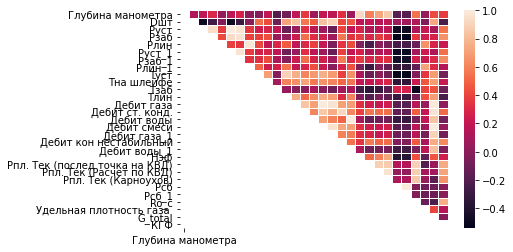

In [10]:
#разбиваем кгф на интервалы
kgf_intervals = kgf_to_intervals(data_frame)
print(kgf_intervals)

#(Интервал соответсвующий значению кгф, g_total данного интрвала - все различные)
class_list = (get_class_set(data_frame, kgf_intervals))
print("class list", class_list)

#{feature : gain_ratio of feature}
gain_ratio_of_features = get_gain_ratio_of_features(data_frame, class_list, kgf_intervals)
correlated_features = get_correlated_features(data_frame)
print(gain_ratio_of_features)

In [11]:
#Сильно корреллирующие признаки удаляем на основе Gain_ratio
for correlated_feature in correlated_features:
        first_cor_feature = correlated_feature[0]
        second_cor_feature = correlated_feature[1]
        if first_cor_feature not in gain_ratio_of_features or second_cor_feature not in gain_ratio_of_features:
            continue
        first_feature_gain_ratio = gain_ratio_of_features[first_cor_feature]
        second_feature_gain_ratio = gain_ratio_of_features[second_cor_feature]
        if first_feature_gain_ratio > second_feature_gain_ratio:
            print("Remove ", second_cor_feature)
            gain_ratio_of_features.pop(second_cor_feature)
        else:
            print("Remove ", first_cor_feature)
            gain_ratio_of_features.pop(first_cor_feature)

for feature in gain_ratio_dict:
    print("Feature ", feature, " with gain_ratio ", gain_ratio_dict[feature])

Remove  Рпл. Тек (послед точка на КВД)
Remove  Дебит ст. конд.
Remove  Нэф
Remove  Рзаб
Remove  Дебит газа_1
Remove  Рпл. Тек (Карноухов)
Remove  Рзаб_1
Remove  Рлин
Remove  Дебит воды
Remove  Руст
Remove  Дебит смеси
Remove  Pсб_1


NameError: name 'gain_ratio_dict' is not defined

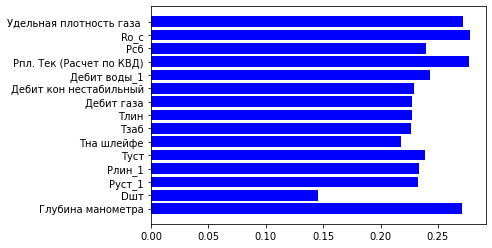

In [12]:
gain_ratio_features = list(gain_ratio_of_features.keys())
gain_ratio_values = list(gain_ratio_of_features.values())

plt.barh(gain_ratio_features, width=gain_ratio_values, color="blue")
plt.show()